# Fake Jobposting Detection
## Introduction:
This dataset contains 18K job descriptions out of which about 800 are fake.
The data consists of both textual information and meta-information about the jobs.
And i can be used to create classification models which can learn the job descriptions which are fraudulent.

Outline:
1. Explore Dataset
  * Data overview
  * Process missing value
  * Feature augmentation
2. Feature Selection
  * Distribution for numerical features
  * Bar and accumulation plots for categorical features
3. Text Processing
  * Tokenize
  * Remove stopwords
  * Lemmatization 
4. Classifiers Related
  * Word Embeddings (countVector, Tf-idf, Fasttext, Glove)
  * Oversampling (SMOTE)
  * Models (Logistic Regression, Random Forest, XGBoost, Neural Network)
4. Bert as encoder
  * For classifier
  * For Neural Network


In [1]:
# import libraries
import re
import dill
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import Lambda, Dense
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.utils import np_utils

from bert4keras.backend import keras, set_gelu
from bert4keras.tokenizers import Tokenizer, SpTokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam, extend_with_piecewise_linear_lr
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from preprocess_job import reset_ind, cate_to_onehot, tokenizer_wt, remove_stopwords, lemmatization
from ultils import standardize, load_dataset, split_col, fit_model
from plot_job import plot_cm, plot_aucprc, plotCateColumn
from vectorize import victorize_countVector, victorize_ft, victorize_glove, victorize_tfidf


warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
# read dataset from file
jobPosting, countryCode = load_dataset()
jobPosting.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
# show the extra dataset
countryCode.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


## 1. Explore Dataset
The first thing is to have a general feel of the data.
There are 17880 rows with 18 columns of features. 95.15% (17014) of data are real posting, while 4.85% (866) are fake.
The dataset contains three kinds of features: textual, categorical and numerical.
We need to process them individually and select valuable features.

Feature Technicalities:

* **Extra dataset:**
We import a dataset (CountryCode) to help us interpret location information, instead of process it as text.
By transferring location information to Codes, it becomes a categorical column, which is more concise than text.
* **Pandas Profiling:**
We make use of a library to generate data report including value and correlation analysis.
* **Feature augmentation:**
We do three things for : 1. change salary range to three features (salary-low, salary-high, difference); 2. For each
textual columns, calculate its word count as a new feature; 3.  Merge all text into one column (meta_text)


### 1.1 Column Types
Generally, there are three kinds of columns:
* Binary columns: All 0/1. They can be used directly.
* Categorical columns: Discrete values. We would explore how to process categories.
* Textual columns: Descriptions with long sentences.
They need to be embedded to vector representation.

We initial these columns name here for further handling.

In [4]:
binary_columns = ["telecommuting", "has_company_logo", "has_questions"]
text_columns = ["title", "company_profile", "description", "requirements", "benefits"]
cate_columns = [ "employment_type", "required_experience", "required_education","industry", "function"]
num_columns = []
label = ["fraudulent"]

### 1.2 Missing value
Since there are quite a lot missing values, we fill them manually instead of dropping them.

In [ ]:
jobPosting.info()

In [5]:
# Fill 'None' to NA cell in category
jobPosting[text_columns] = jobPosting[text_columns].fillna(' ')
jobPosting[cate_columns] = jobPosting[cate_columns].fillna("None")
jobPosting.salary_range = jobPosting.salary_range.fillna("0-0")


### 1.3 Feature Augmentation
  * Add word count columns for each textual columns, as well as overall count.

In [6]:
# add word count features for each textual content
jobPosting["overall_count"] = 0
num_columns.append("overall_count")
for col in text_columns:
    count_list = jobPosting[col].str.split(' ').map(lambda x: len(x))
    jobPosting[col + '_count'] = count_list
    jobPosting["overall_count"] += count_list
    num_columns.append(col + '_count')

  * Dived salary to salary_low, salary_high. And calculate salary difference

In [7]:
# Add salary features

# use regular expression to extract lower and upper bound
salary = []
for st in jobPosting.salary_range:
    matches = re.finditer(r'\d+', st)
    salary.append([int(m.group(0)) for m in matches])

# store info in salary_df
salary_df = pd.DataFrame(salary)
salary_df.columns = ["salary_low", "salary_high"]
salary_df["salary_low"][salary_df["salary_high"].isna()] = -1
salary_df["salary_high"][salary_df["salary_high"].isna()] = -1
salary_df["salary_high"] = salary_df["salary_high"].astype(int)
salary_df["salary_diff"] = salary_df["salary_high"] - salary_df["salary_low"]

# merge salary with dataset
jobPosting = jobPosting.join(salary_df)
jobPosting.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,fraudulent,overall_count,title_count,company_profile_count,description_count,requirements_count,benefits_count,salary_low,salary_high,salary_diff
0,1,Marketing Intern,"US, NY, New York",Marketing,0-0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,...,0,384,2,141,124,115,2,0,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,0-0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,877,6,150,309,187,225,0,0,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,0-0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,...,0,356,4,136,50,164,2,0,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,0-0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,705,5,85,345,174,96,0,0,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,0-0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,0,482,3,205,182,89,3,0,0,0


* Convert location from text to category using extra dataset. Fill NA and exceptions as "Others"

In [8]:
# country code as a new column named country
def process_location(df, column):
    for loc in df[column]:
        code = str(loc)[:str(loc).find(',')]
        if countryCode.Code.isin([code]).any():
            yield code
        else:
            yield "Others"

jobPosting["country"] = list(process_location(jobPosting, "location"))
cate_columns.append('country')

* Generate data report including value and correlation analysis.

In [9]:
# use pandas-profiling to generate report
profile = ProfileReport(jobPosting[cate_columns + binary_columns + num_columns + label], 
                        title='Data Report', 
                        html={'style':{'full_width':True}}
                       )
profile.to_file(output_file="data_report.html")

build report structure: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


From the report, we can gain some insights:
1. There are 13.4% duplicate rows, but we should not remove them in order to keep data's original distribution
* 'Industry' and 'country' have high cardinality (around 100)
* From Spearman's Correlation, "company logo" and "profile_count" are very strong features in this case.
* From Phik Correlation (including categories), "country" and "education" are strong features
* We should delete "telecommuting" and "title count"

[Click to view report](./data_report.html)

## 2. Feature  selection
With information above, we would like to select valuable features and get rid of noise.
We can confirm features' relation with fraudulent by plotting distribution.

### 2.1 Numeric features

The plots indicates it is good to keep "overall_count", "company_profile_count".

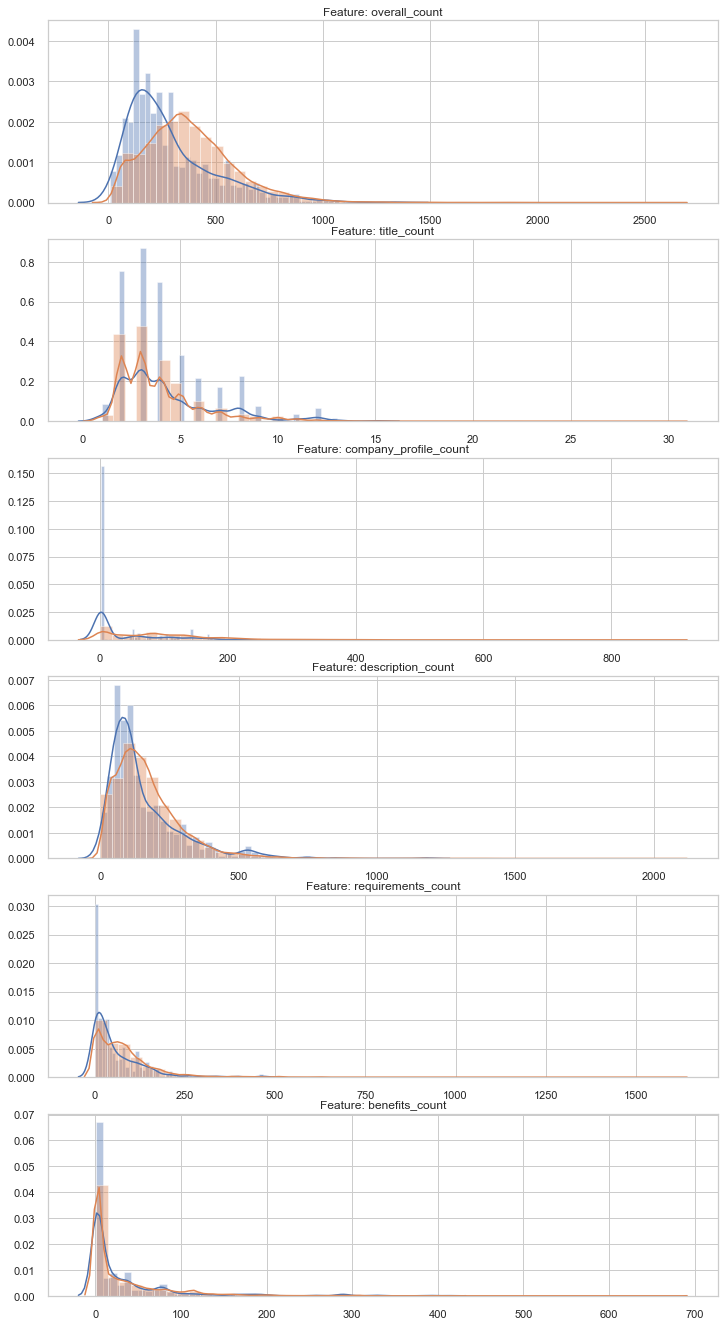

In [10]:
# draw plot for numerical columns
plt.figure(figsize=(12,30*4))
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(jobPosting[num_columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(jobPosting[feature][jobPosting.fraudulent == 1], bins=50)
    sns.distplot(jobPosting[feature][jobPosting.fraudulent == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()


* For salary, since salary is highly-skewed, it is better to mute NA values and check distribution.
Maybe it is a magic feature. So we have the log(salary) distribution.
Sadly, the distribution are similar. And we should not include these feature.

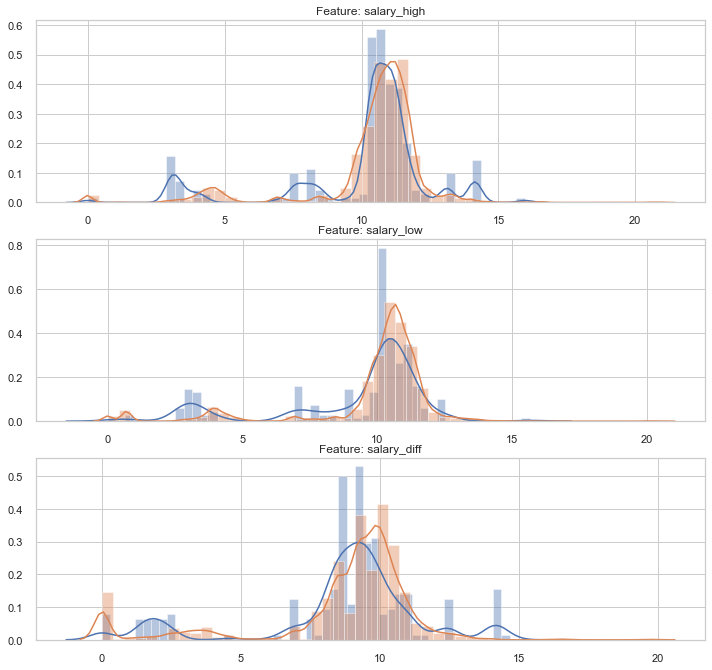

In [11]:
# draw distribution for salary
plt.figure(figsize=(12,30*4))
t = jobPosting[ jobPosting["salary_range"]!="0-0"]
t['salary_low'] = np.log(t['salary_low']+2)
t['salary_high'] = np.log(t['salary_high']+2)
t['salary_diff'] = np.log(t['salary_diff']+1)
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(['salary_high', 'salary_low', 'salary_diff']):
    ax = plt.subplot(gs[i])
    sns.distplot(t[feature][t.fraudulent == 1], bins=50)
    sns.distplot(t[feature][t.fraudulent == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

In [12]:
# fix the num_columns
num_columns = ["overall_count", "company_profile_count"]
binary_columns = ['has_company_logo', 'has_questions']

### 2.2 Categorical columns

We extract the country codes from location as categorical data.
With the help a new dataset named countryCode, we can verify them.
For those unknown codes, they are renamed to "Others".

We not only draw percentage of fraud in each category,
but also, in fraud ratio sorted dataframe, we draw accumulated line for total and fraudulent.
The area between two lines represent the ability of this category.

* Location

Location is a strong feature.
In accumulation plot, fraudulent reach 1.0 at x=18 while total_count just past 0.8.
This can be interpret as: if any data not belong to the top 18 countries, then it is not likely fake.

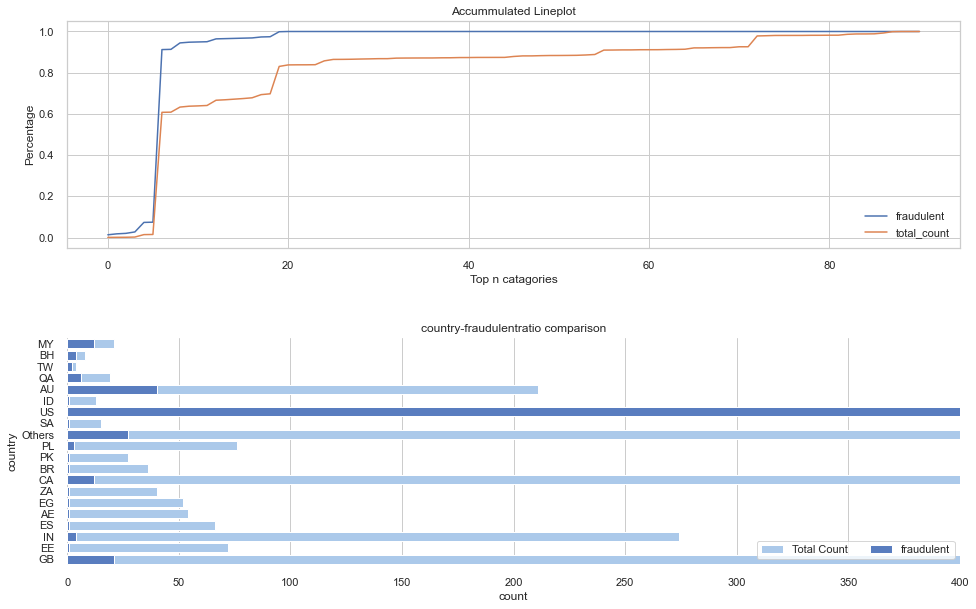

,country,fraudulent,total_count,ratio
55,MY,12,21,0.571429
9,BH,4,8,0.500000
83,TW,2,4,0.500000
68,QA,6,19,0.315789
5,AU,40,211,0.189573
33,ID,1,13,0.076923
86,US,725,10593,0.068441
72,SA,1,15,0.066667
61,Others,27,440,0.061364
66,PL,3,76,0.039474


In [13]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="country",
               xlim_bar=(0,400),
               sort_by= 'ratio').head(10)

* Industry

It is a good feature. Same analysis as before: flatulent line reach much early than total_count.

In [14]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="industry",
               xlim_bar=(0,200),
               sort_by= 'ratio').head(10)

,industry,fraudulent,total_count,ratio
107,Ranching,1,1,1.000000
81,Military,1,2,0.500000
3,Animation,2,5,0.400000
89,Oil & Energy,109,287,0.379791
0,Accounting,57,159,0.358491
67,"Leisure, Travel & Tourism",21,76,0.276316
21,Computer Networking,12,44,0.272727
36,Executive Office,2,8,0.250000
28,Defense & Space,2,9,0.222222
63,Investment Management,1,6,0.166667


* Function

Same as before. But it is not as strong as Location or Industry.

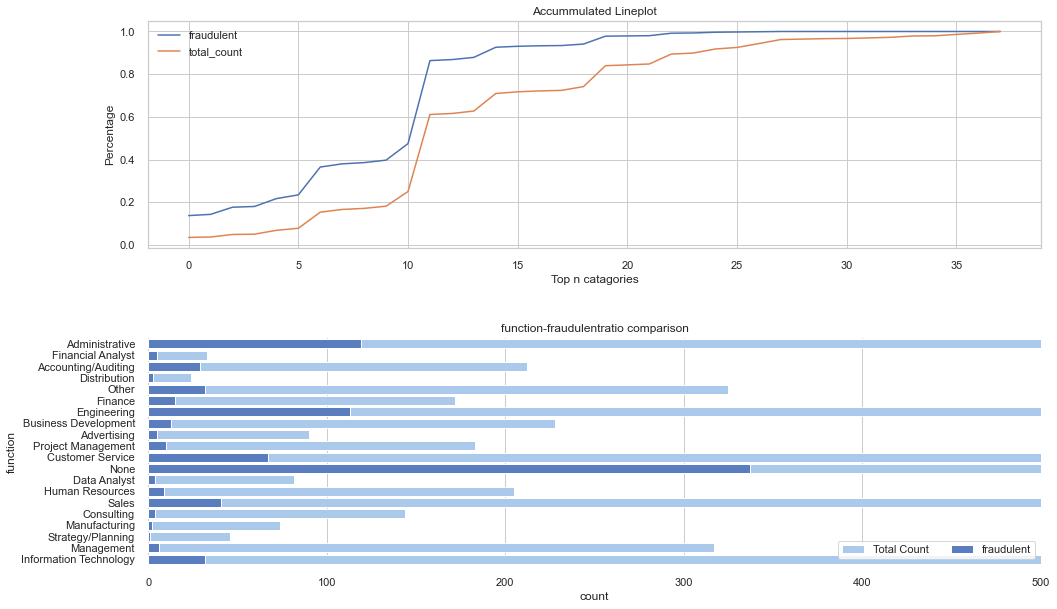

,function,fraudulent,total_count,ratio
1,Administrative,119,630,0.188889
14,Financial Analyst,5,33,0.151515
0,Accounting/Auditing,29,212,0.136792
10,Distribution,3,24,0.125000
24,Other,32,325,0.098462
13,Finance,15,172,0.087209
12,Engineering,113,1348,0.083828
5,Business Development,13,228,0.057018
2,Advertising,5,90,0.055556
27,Project Management,10,183,0.054645


In [15]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="function",
               xlim_bar=(0,500),
               sort_by= 'ratio').head(10)

* Employment_type

This is the feature we'd better to mute, since two lines converge nearly at the same time.
Since there is space between two lines in the middle, it is possible to combine with other feature and become magic.
Thus, I choose not to ignore this feature.

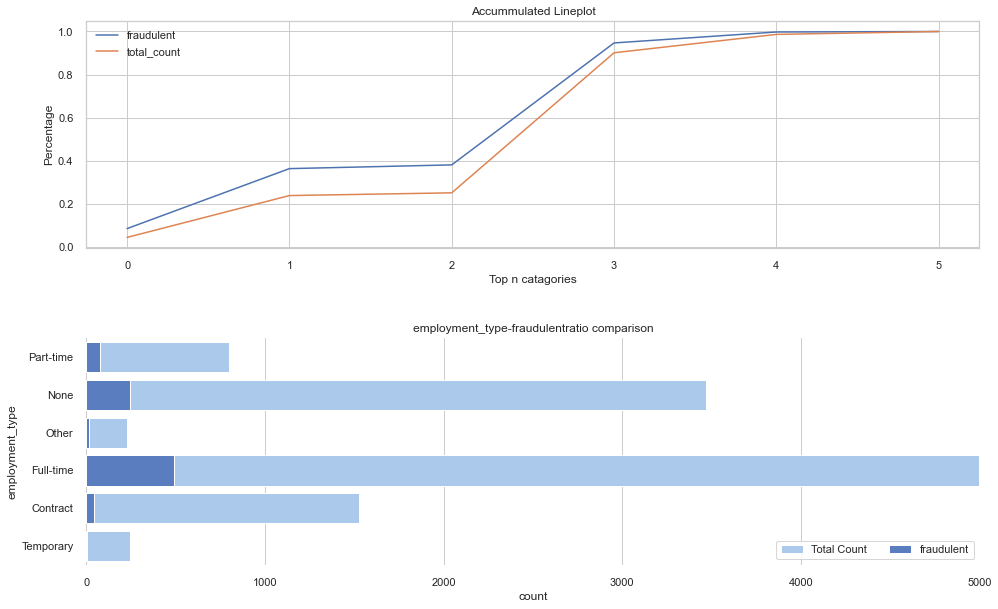

,employment_type,fraudulent,total_count,ratio
4,Part-time,74,797,0.092848
2,None,241,3471,0.069432
3,Other,15,227,0.066079
1,Full-time,490,11620,0.042169
0,Contract,44,1524,0.028871
5,Temporary,2,241,0.008299


In [16]:
plotCateColumn(data=jobPosting[cate_columns+label],
               ratio_col="fraudulent",
               group_by="employment_type",
               xlim_bar=(0,5000),
               sort_by= 'ratio').head(10)

In [17]:
# fix categorical columns
cate_columns = [ "employment_type", "required_experience", "required_education", "industry", "function"]

## 3. Text Processing:
Here we use a function to customize our preprocess.

Feature Technicalities:

* **Tokenizer:**
The module is to grab tokens in document, as well as get rid of punctuation/URL/number/separator etc.
* **Remove stop words:**
Stop means words to support sentence structure like "this", "a" etc.
They are usually unimportant.
* **Lemmatization:**
This step convert words to their root, like apples->apple. I also set PoS tag for filter.

In [18]:
# set function for preprocessing
def preprocessing(docs):
    docs = list(tokenizer_wt(docs)) # or use tokenizer_sp: simple_process in Gensim
    docs = list(remove_stopwords(docs))
    docs = list(lemmatization(docs))
    return docs

In [19]:
# join textual columns together
jobPosting['meta_text'] = jobPosting[text_columns].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# preprocessing dataset
jobPosting['corpus'] = preprocessing(jobPosting['meta_text'])
jobPosting['corpus'][0]

100%|██████████| 17880/17880 [12:11<00:00, 24.45it/s]


'marketing intern create award win cooking site support connect celebrate home cook give need place top editorial business engineering team focus use technology find new well way connect people specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well know professional partnership whole food market name good food feature daily techcrunch today show re locate fast grow win online food crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive headquarter reproduce repackage exist content number partner site buzzfeed various content management systemsresearche blog website provision affiliate programassisting day day affiliate program support screening affiliate assist affiliate pr amp event neededhelpe office administrative work filing mailing prepare meetingsworke developer document bug suggest improvement sitesupporte marketing executive staff exper

## 4. Classifiers 
This part shows:

1. how to generate the train, valid, test dataset;
2. how to use SMOTE Oversampling for imbalance training set;
3. the results of different models including Logistic Regression, Random Forest, XGBoost, Neural Network.


### 4.1 Build datasets
We first split original dataset with stratify methods into 3: training, validation and testing.
And we use training as validation datasets for modeling choosing and parameter tuning.
At last, train model with training+validation, use test set to evaluate results.

Note: Formally, we should use K-Fold Validation and Grid Search to fine tuning parameter.
Due to the time limit, I choose split validation manually, and find parameter according to few experiments.

In [20]:
# Splitting the dataset into the Training, Valid and Test set
data_df = jobPosting[['corpus'] + num_columns + binary_columns + cate_columns + label]
data_train, data_test = train_test_split(data_df, test_size = 0.2, stratify=data_df[label], random_state = 42)
data_train, data_valid = train_test_split(data_train, test_size = 0.2, stratify=data_train[label], random_state = 42)

# Use data_train to train OneHot Encoder, then use it to represent validation and test categories
data_train, data_valid, data_test = reset_ind(data_train, data_valid, data_test)
data_train, data_valid, data_test = cate_to_onehot(data_train, data_valid, data_test, cate_columns)

# print data shape
print("Shape of training data: ", data_train.shape)
print("Shape of validation data: ", data_valid.shape)
print("Shape of testing data: ", data_test.shape)

Shape of training data:  (11443, 200)
Shape of validation data:  (2861, 200)
Shape of testing data:  (3576, 200)


In [21]:
# set text column
text_col = 'corpus'

# split data and label
X_train, y_train = split_col(data_train, label)
X_valid, y_valid = split_col(data_valid, label)
X_test, y_test = split_col(data_test, label)

# use different model to represent text
X_train_countVector, X_valid_countVector = victorize_countVector(X_train, X_valid, text_col)
X_train_tfidf, X_valid_tfidf = victorize_tfidf(X_train, X_valid, text_col)
X_train_ft, X_valid_ft = victorize_ft(X_train, X_valid, text_col) # 300 dimensions for text
X_train_glove, X_valid_glove = victorize_glove(X_train, X_valid, text_col) # 300 dimension for text

# standardize every dataset
X_train_glove_std, X_valid_glove_std = standardize(X_train_glove, X_valid_glove, with_mean=False)
X_train_tfidf_std, X_valid_tfidf_std = standardize(X_train_tfidf, X_valid_tfidf, with_mean=False)
X_train_countVector_std, X_valid_countVector_std = standardize(X_train_countVector, X_valid_countVector, with_mean=False)
X_train_ft_std, X_valid_ft_std = standardize(X_train_ft, X_valid_ft, with_mean=False)

# use smote to upper sampling
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_ft_std_res, y_train_res = smote.fit_sample(X_train_ft_std, y_train)
X_train_countVector_std_res, y_train_res = smote.fit_sample(X_train_countVector_std, y_train)
X_train_tfidf_std_res, y_train_res = smote.fit_sample(X_train_tfidf_std, y_train)
X_train_glove_std_res, y_train_res = smote.fit_sample(X_train_glove_std, y_train)

# Print shape after oversampling
print("Shape of X_train_ft_std_res: ", X_train_ft_std_res.shape)
print("Shape of y_train_res: ", y_train_res.shape)



Shape of X_train_ft_std_res:  (21778, 498)
Shape of y_train_res:  (21778, 1)


In [1]:
import dill
dill.dump_session('./env/notebook_env.db')
# dill.load_session('./env/notebook_env.db')

Using TensorFlow backend.


### 4.2 Logistic Regression

From the results below, we can find some insights:

1. countVector and Tfidf, these two straight forward model get impressive results, while the others are blow 0.7.
It might because Logistic Regression is suitable for interpretable feature like count. 
But it is naive for fasttext and Glove that their advantages cannot show. 
This idea is confirmed by trainged XGBoost using fasttext: 
The precision-recall score raise from 0.6 to 0.8. 
If we trained use a suitable structure, the result could be better.
2. Dataset with Standardize and Oversampling in most case have better result in a same model. 
Thus, we will choose dataset with all processing to train remaining models.

#### 4.2.1 countVector representation (base)
The baseline is really great that reach 0.87 Average Percsion.
And FN is 37; FP is 11, which means the model tents to make safe decision.

Recall=0.734 
Precision=0.903
F1=0.810


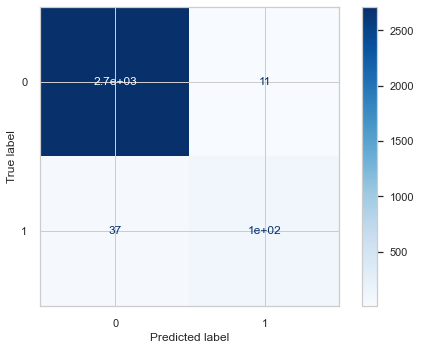

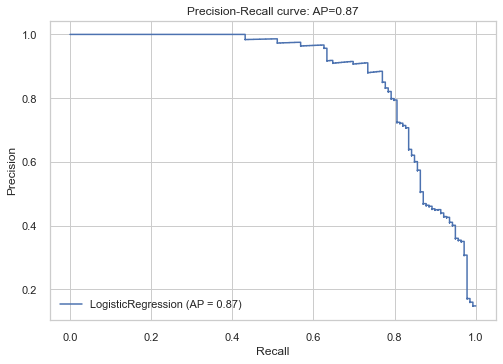

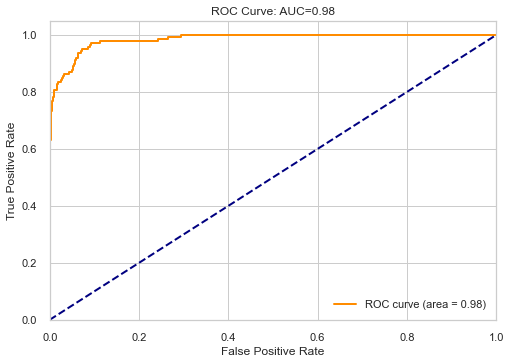

In [2]:
# Train logistic regression model by countVector
countVector_lr = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
countVector_lr = fit_model(countVector_lr, X_train_countVector, y_train, X_valid_countVector, y_valid)

#### 4.2.2 countVector representation (Standardize)
After Standardize, the results are improved.

Recall=0.734 
Precision=0.936
F1=0.823


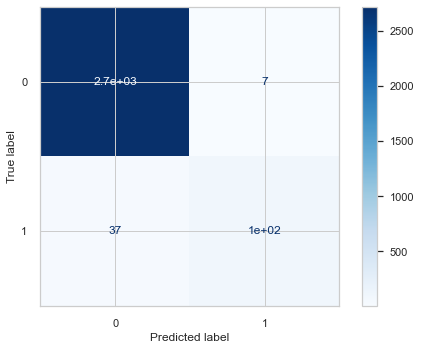

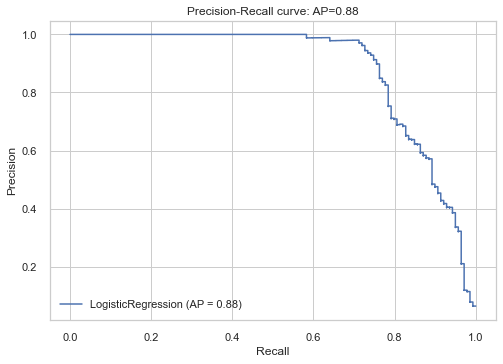

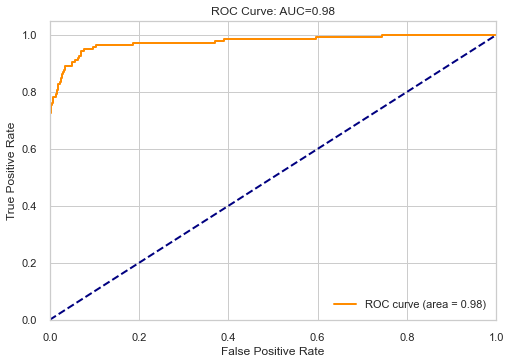

In [3]:
# Train logistic regression model by countVector
countVector_lr_std = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
countVector_lr_std = fit_model(countVector_lr_std, X_train_countVector_std, y_train, X_valid_countVector_std, y_valid)

#### 4.2.3 countVector representation (Standardize + Oversampling)
With Oversampling, we can see FP increases to 39 while TP decrease to 29. 
This means the model star to learn the feature of Fraudulent. 
But due to the oversampling strategy or data size, the policy is not that correct.

Recall=0.791 
Precision=0.738
F1=0.764


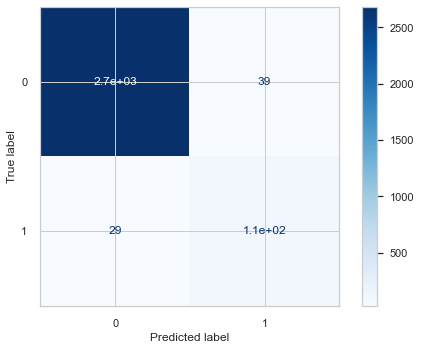

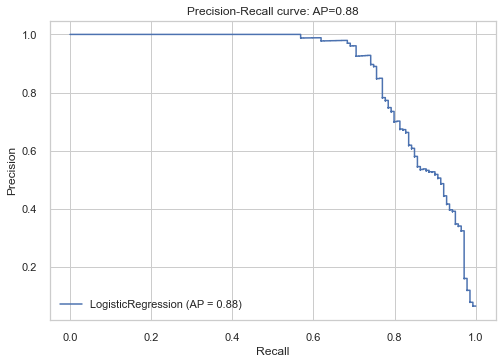

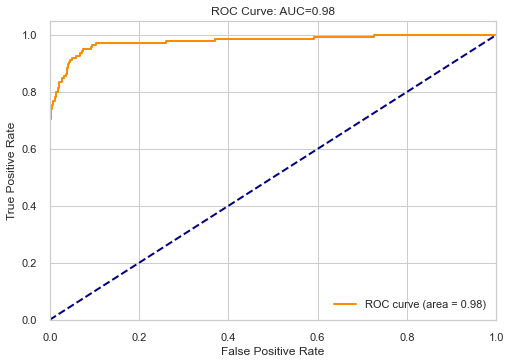

In [4]:
# Train logistic regression model by countVector
countVector_lr_std_res = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
countVector_lr_std_res = fit_model(countVector_lr_std_res, X_train_countVector_std_res, y_train_res, X_valid_countVector_std, y_valid)

Conlusion:

After comparing different word representation, 
we find that standardized and oversampled data get best performance in most cases.
Thus, below parts only show restults with the dataset after standardize and oversampling .

#### 4.2.4 Tfidf representation (Standardize + Oversampling)
It is so impressive that Precision is 0.99 in this case. 
And we can see Tfidf do express more information that word count.

Recall=0.741 
Precision=0.990
F1=0.848


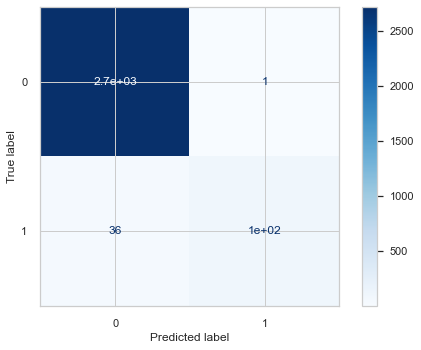

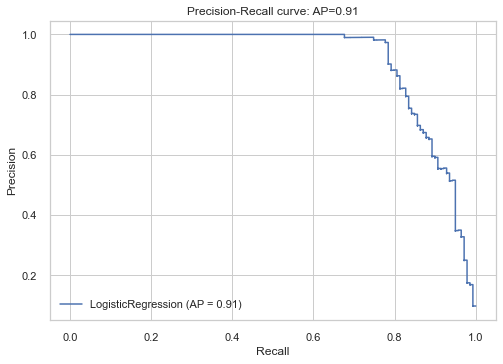

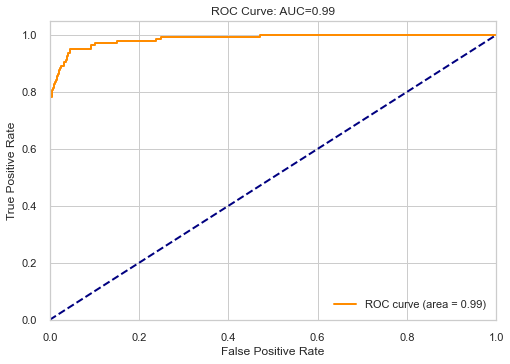

In [5]:
# Train logistic regression model by Tfidf
tfidf_lr_std_res = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
tfidf_lr_std_res = fit_model(tfidf_lr_std_res, X_train_tfidf_std_res, y_train_res, X_valid_tfidf_std, y_valid)

#### 4.2.5 Fasttext representation (Standardize + Oversampling)
The fasttext model has 300 dimentions, trained for 100 epoches. 
The Precision-Recall Curve indicates that the model is not stable. 
Maybe Fasttext cannot be well-expressed in Logistic Regression due to the simple structure.
If we trained with deeper model like XGBoost., the performance might be improved greatly.

Recall=0.784 
Precision=0.474
F1=0.591


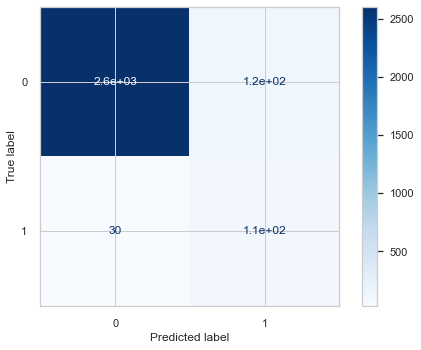

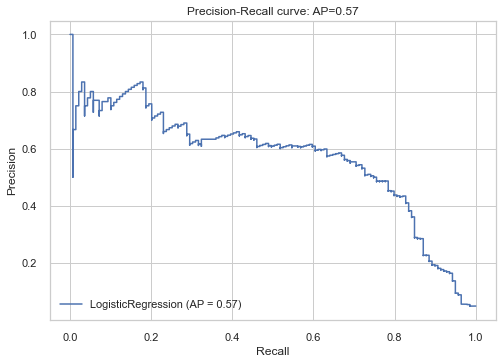

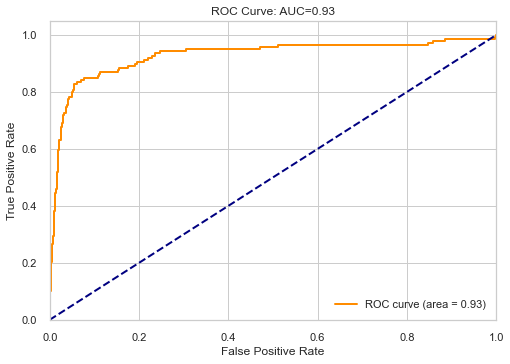

In [6]:
# Train logistic regression model by Fasttext
ft_lr_std_res = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
ft_lr_std_res = fit_model(ft_lr_std_res, X_train_ft_std_res, y_train_res, X_valid_ft_std, y_valid)

So we try train a XGBoost model using Fasttext.
As we said, the result do improves a lot although it is not as good as tfidf.
Thus, better results could be achieved for further fine tuning.

Recall=0.727 
Precision=0.856
F1=0.786


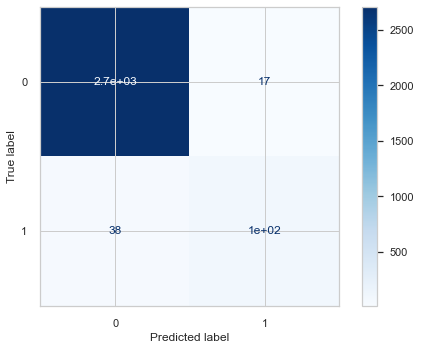

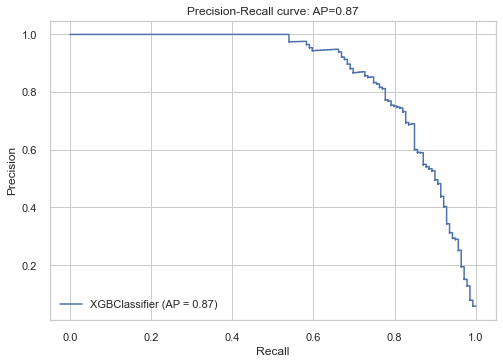

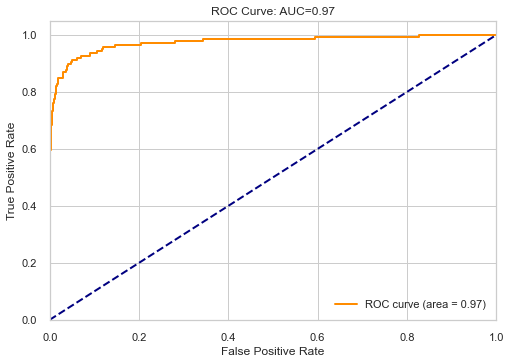

In [7]:
ft_xgb_std_res = XGBClassifier(random_state = 42, n_jobs = -1,
                    n_estimators=100, 
                    criterion = 'entropy')
ft_xgb_std_res = fit_model(ft_xgb_std_res, X_train_ft_std_res, y_train_res, X_valid_ft_std, y_valid)


#### 4.2.6 Glove Representation (Standardize + Oversampling)
The situation is similar to fasttext's.
Logistic Regression gives model sooo bad perfomance that 480 are wrongly classified to fake.
Let's see XGBoost for Glove

Recall=0.791 
Precision=0.186
F1=0.302


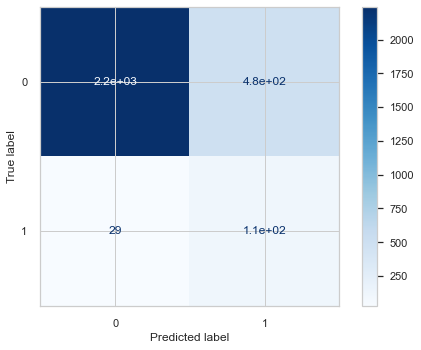

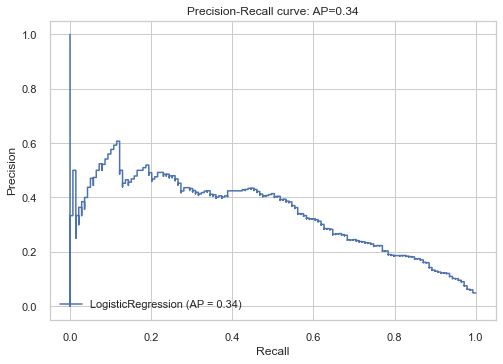

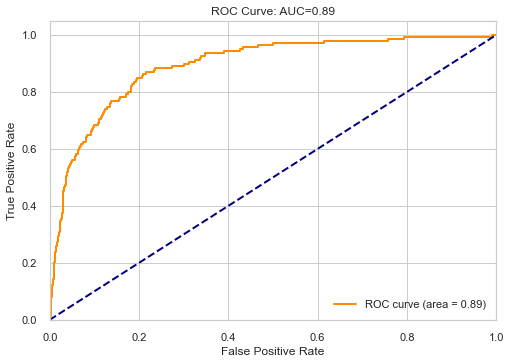

In [8]:
# Train logistic regression model by Glove
glove_lr_std_res = LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
glove_lr_std_res = fit_model(glove_lr_std_res, X_train_glove_std_res, y_train_res, X_valid_glove_std, y_valid)


The result is yes! Glove is greatly improved to 0.79 AP score.
The FP returns to 10 instead of 400+.
We can expect more on model like Neural network.

Recall=0.568 
Precision=0.888
F1=0.693


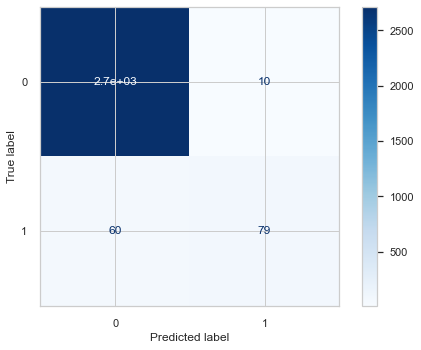

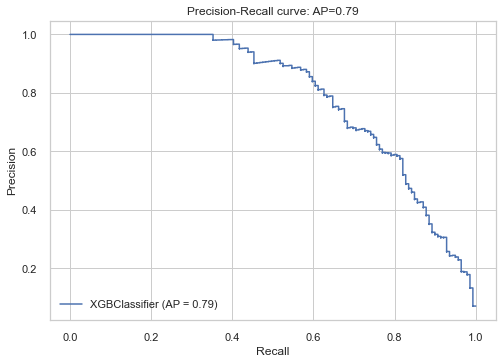

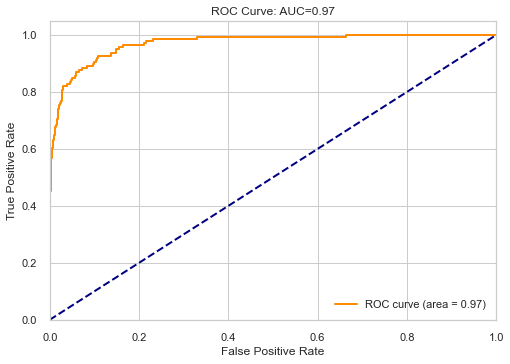

In [9]:

glove_xgb_std_res = XGBClassifier(random_state = 42, n_jobs = -1,
                        n_estimators=1000, 
                        criterion = 'entropy')
glove_xgb_std_res = fit_model(glove_xgb_std_res, X_train_glove_std_res, y_train_res, X_valid_glove_std, y_valid)

Conlusion:

Tfidf get the best result, so we will use this representation for further exploration.

### 4.3 Random Forest
Although this model reach same AP score as Logistic Regression. 
But from confusion matrix, we can see that FN become higher.
It is possible that model is overfitting.
And interpret fake posting using more strict rules.

Recall=0.583 
Precision=0.976
F1=0.730


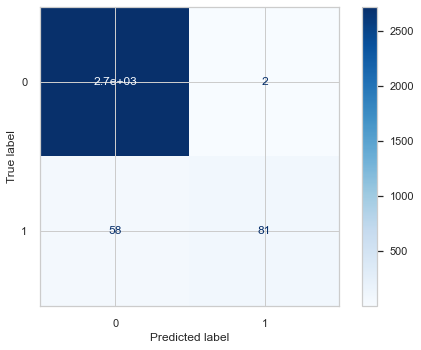

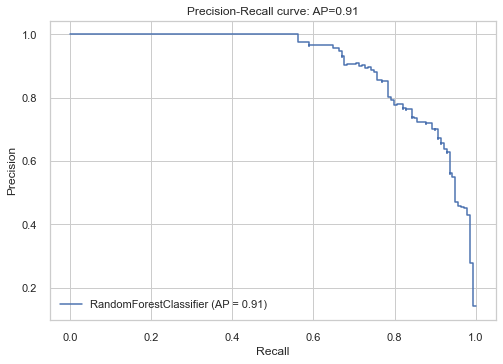

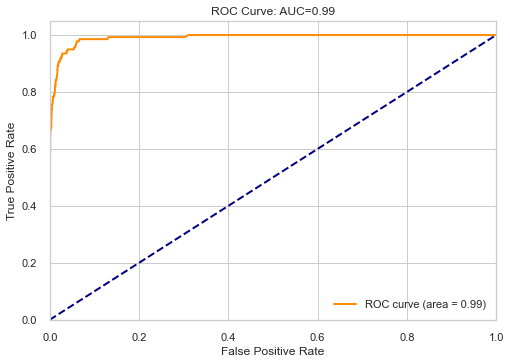

In [10]:
tfidf_rf_std_res = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=1000,
                             max_features= 'auto', 
                             criterion = 'entropy')
tfidf_rf_std_res = fit_model(tfidf_rf_std_res, X_train_tfidf_std_res, y_train_res, X_valid_tfidf_std, y_valid)

So I manually set n_estimators to 500 to confirm the idea.
The performace is nearly same, which means model do overfitting. 
Generally, we should use GridSearch to find the best setting.

Recall=0.590 
Precision=0.976
F1=0.735


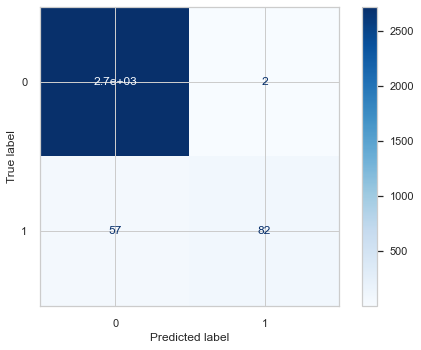

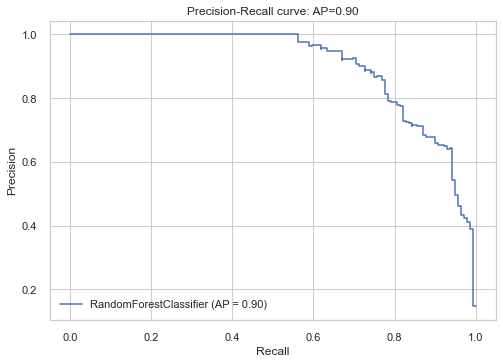

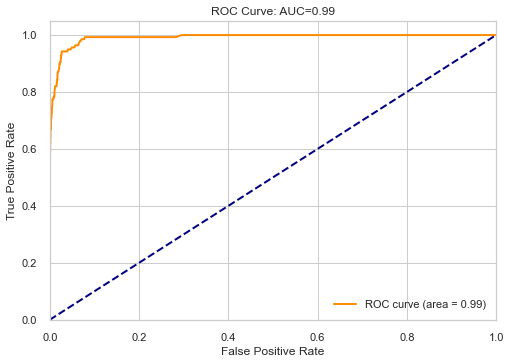

In [37]:
tfidf_rf_std_res = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=500,
                             max_features= 'auto', 
                             criterion = 'entropy')
tfidf_rf_std_res = fit_model(tfidf_rf_std_res, X_train_tfidf_std_res, y_train_res, X_valid_tfidf_std, y_valid)

### 4.4 XGBoost
XGBoost have a better performance than Random Forest

Recall=0.683 
Precision=0.931
F1=0.788


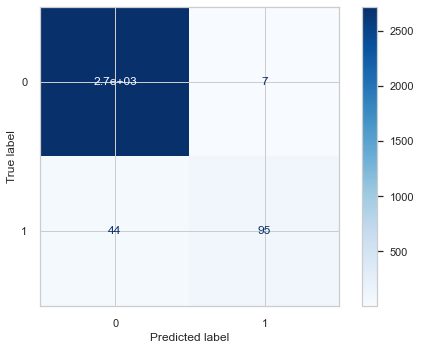

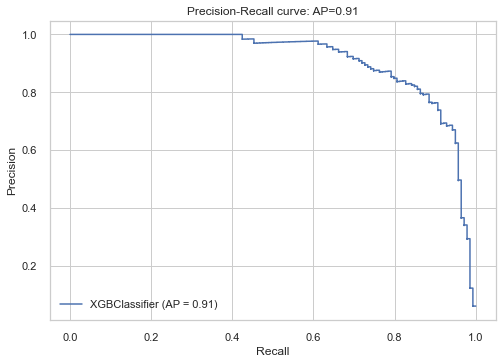

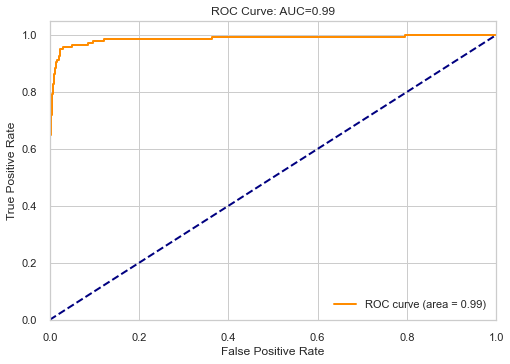

In [15]:
tfidf_xgb_std_res = XGBClassifier(random_state = 42, n_jobs = -1,
                    n_estimators=1000, 
                    criterion = 'entropy')
tfidf_xgb_std_res = fit_model(tfidf_xgb_std_res, X_train_tfidf_std_res, y_train_res, X_valid_tfidf_std, y_valid)

### 4.5 Neural Network

We also try to build Neural Network using tfidf. The result suggests that simple NN could also be used for classification. But better perfomance need longer training and deeper network.

In [12]:
def build_nn(dim):
    model = Sequential()

    model.add(Dense(256, input_dim=dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Epoch 1/10
21778/21778 [==============================] - 72s 3ms/step - loss: 0.0750 - accuracy: 0.9771
Epoch 2/10
21778/21778 [==============================] - 70s 3ms/step - loss: 0.0234 - accuracy: 0.9934
Epoch 3/10
21778/21778 [==============================] - 72s 3ms/step - loss: 0.0099 - accuracy: 0.9977
Epoch 4/10
21778/21778 [==============================] - 72s 3ms/step - loss: 0.0100 - accuracy: 0.9981
Epoch 5/10
21778/21778 [==============================] - 71s 3ms/step - loss: 0.0050 - accuracy: 0.9990
Epoch 6/10
21778/21778 [==============================] - 71s 3ms/step - loss: 0.0111 - accuracy: 0.9969
Epoch 7/10
21778/21778 [==============================] - 70s 3ms/step - loss: 0.0073 - accuracy: 0.9981
Epoch 8/10
21778/21778 [==============================] - 70s 3ms/step - loss: 0.0059 - accuracy: 0.9983
Epoch 9/10
21778/21778 [==============================] - 71s 3ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 10/10
21778/21778 [==============================

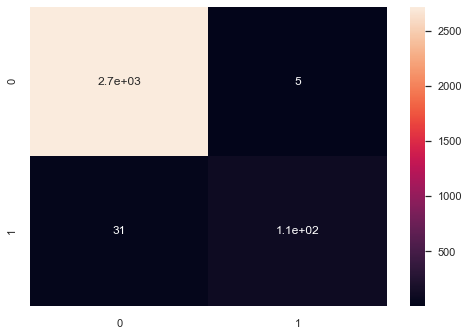

In [38]:
# get the dim for 1st layer
dim = X_train_tfidf_std_res.shape[1]

# build the model and train
tfidf_nn_std_res = build_nn(dim)
tfidf_nn_std_res.fit(X_train_tfidf_std_res, y=y_train_res, batch_size=64, 
          epochs=10, verbose=1)

# plot confusion matrix
plot_cm(tfidf_nn_std_res, X_valid_tfidf_std, y_valid)

## 5.Bert 
Bert can be viewed as encoder that give proper vector based on context.
Not like fasttext and glove, thie kind representation consider the words having differet meaning.

Note: This part needs lots of time to train, so I just give a demo code for the idea.

### 5.1 For Classifier
The idea is use Bert pretrained model to get < CLS > vector for a document. 
We first use Bert tokenizer to encode our dataset.
And pass them to Bert model to get the vector for < CLS >.
Then combine this vector with other numerical features.
Feed them all to classifiers.

In [ ]:

# Set bert path
config_path = './bert_base/bert_config.json'
checkpoint_path = './bert_base/bert_model.ckpt'
dict_path = './bert_base/vocab.txt'

# Set tokenizer form path
tokenizer = Tokenizer(dict_path, do_lower_case=True)  

# load pretrain model
model = build_transformer_model(config_path, checkpoint_path)  

# Encoder docs to a (:, 768) vector
docs = jobPosting['meta_text']
text_vec = np.empty((0,768), float)
for text in tqdm(docs):
    token_ids, segment_ids = tokenizer.encode(text, max_length=10)
    vec = model.predict([np.array([token_ids]), np.array([segment_ids])])[:, 0]
    text_vec = np.append(text_vec, vec, axis = 0)

print(text_vec.shape)

# data_df = text_vec + Other_feature
# Seplit data_df to train, valid and test.
# Use them to train classifier as before


### 5.2 For Neural Network
The code is adapted from the example of bert4keras. 
It uses ALbert pretrain model to encode text. 
And take the CLS to a dense layer for classification which is the same idea.
The difference is model output is connected to a dense layer for classfication.

The model needs 10 hours to train.


In [ ]:
set_gelu('tanh')  # switch to tanh

num_classes = 2
maxlen = 128
batch_size = 32
config_path = './albert_base_en_tfhub/albert_config.json'
checkpoint_path = './albert_base_en_tfhub/variables/variables'
sentencepiece_model_path = "./albert_base_en_tfhub/assets/30k-clean.model"

col_text = 'corpus'
col_label = 'fraudulent'

def load_data(df, col_text, col_label):
    D = []
    for index, row in df[[col_text, col_label]].iterrows():
        D.append((row[col_text], int(row[col_label])))
    return D

# load dataset
train_data = load_data(data_train, col_text, col_label)
valid_data = load_data(data_valid, col_text, col_label)
test_data = load_data(data_test, col_text, col_label)

# setup tokenizer
tokenizer = SpTokenizer(sentencepiece_model_path)

class data_generator(DataGenerator):
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, (text, label) in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(text, max_length=maxlen)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append([label])
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []


# load pretrained model
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    model='albert',
    return_keras_model=False
)

output = Lambda(lambda x: x[:, 0], name='CLS-token')(bert.model.output)
output = Dense(
    units=num_classes,
    activation='softmax',
    kernel_initializer=bert.initializer
)(output)

model = keras.models.Model(bert.model.input, output)
model.summary()

# extend to piecewise linear optimizer
AdamLR = extend_with_piecewise_linear_lr(Adam, name='AdamLR')

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=AdamLR(learning_rate=1e-4, lr_schedule={
        1000: 1,
        2000: 0.1
    }),
    metrics=['accuracy'],
)

#  set generator
train_generator = data_generator(train_data, batch_size)
valid_generator = data_generator(valid_data, batch_size)
test_generator = data_generator(test_data, batch_size)


def evaluate(data):
    total, right = 0., 0.
    for x_true, y_true in data:
        y_pred = model.predict(x_true).argmax(axis=1)
        y_true = y_true[:, 0]
        total += len(y_true)
        right += (y_true == y_pred).sum()
    return right / total


class Evaluator(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            model.save_weights('best_model.weights')
        test_acc = evaluate(test_generator)
        print(
            u'val_acc: %.5f, best_val_acc: %.5f, test_acc: %.5f\n' %
            (val_acc, self.best_val_acc, test_acc)
        )


evaluator = Evaluator()
model.fit_generator(
    train_generator.forfit(),
    steps_per_epoch=len(train_generator),
    epochs=10,
    callbacks=[evaluator]
)

model.load_weights('best_model.weights')
print(u'final test acc: %05f\n' % (evaluate(test_generator)))







## Summary:
1. This project properly clean the dataset, and import an extra dataset to help extraction features.
2. Implement feature augmentation and selection to improve performance
3. This project ueses different methods process 3 kinds of data: 
  * category -> Onehot Encoding; 
  * number-> Standardize; 
  * Text -> Word Embedding
4. Briefly explore models including Logistic regression, Random forest, XGBoost and Neural Network
5. Finely define function, which makes training process easily.
5. Give the demo to using Bert as encoder

## Future work:
1. Optimize function interface, like use **kws to pass serveral var
2. Make a class for similar functions like Vectorize
3. Use deeper network to train Fasttex and Glove
4. Compare the results using Bert